In [9]:
from yuning_util.dev_mode import DevMode
pkg_dev = DevMode(pkg='k-seq')
pkg_dev.on()

from importlib import reload
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams["figure.dpi"] = 300
plt.style.use('seaborn')

from k_seq.data import count_file, seq_table, seq_table_vis, transform
from k_seq.utility import func_tools
reload(func_tools)
reload(seq_table_vis)
reload(seq_table)
reload(transform)

<module 'k_seq.data.transform' from '/home/yuning/research/k-seq/src/k_seq/data/transform.py'>

# Load count file data from `SeqTable`
* by default, it loads from a pickled dataset object, it is optional to recalculate it from count files

In [2]:
byo_doped = seq_table.SeqTable.load_dataset(dataset='byo-doped')

Load BYO-doped pool data from pickled record from /mnt/storage/projects/k-seq/datasets/byo-doped.pkl
Imported!


In [4]:
byo_doped.sample_overview()

,name,sample type,x value,unique seqs,total counts,"dna amount (from spike-in, ng)",spike-in rad,spike-in pct,"dna amount (from total dna, ng)"
A1,A1,reacted,0.001250,325072,12004474,126.695627,4,0.015786,123.000005
A2,A2,reacted,0.001250,286894,11752226,157.866665,4,0.012669,128.000000
A3,A3,reacted,0.001250,447832,24822840,257.599884,4,0.007764,182.000016
B1,B1,reacted,0.000250,154859,11116634,142.823074,4,0.014003,115.000002
B2,B2,reacted,0.000250,161226,12552203,138.427639,4,0.014448,111.499998
B3,B3,reacted,0.000250,142257,11352810,133.630858,4,0.014967,97.999996
C1,C1,reacted,0.000050,245902,8935891,73.227002,4,0.013656,50.000000
C2,C2,reacted,0.000050,160632,9571053,48.497862,4,0.020619,34.500000
C3,C3,reacted,0.000050,171873,10536759,60.358361,4,0.016568,46.000001
D1,D1,reacted,0.000010,393249,12523217,16.236927,4,0.012318,10.788097


## Sample overview characterization

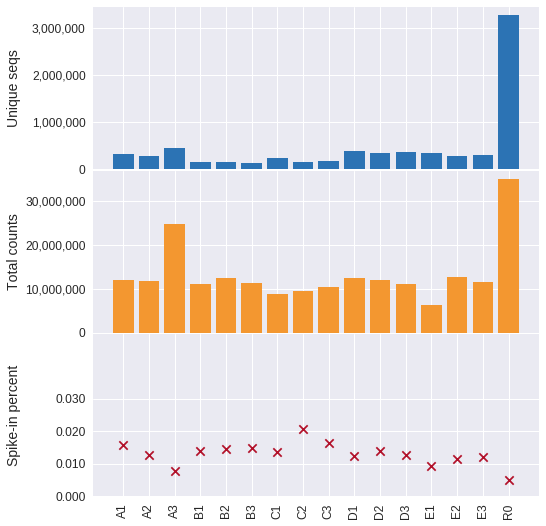

In [5]:
seq_table_vis.sample_overview_plots(seq_table=byo_doped)

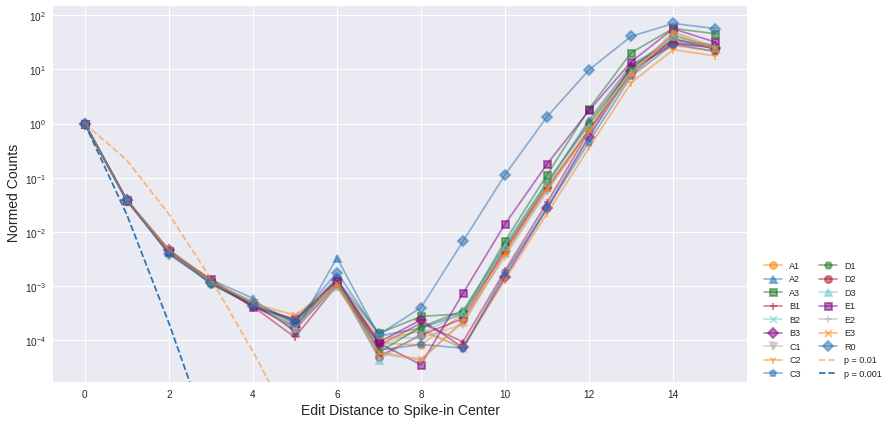

In [8]:
from k_seq.data import transform

transform.spike_in_peak_plot(byo_doped.spike_in, err_guild_lines=[1e-2, 1e-3])
plt.show()

## [Legacy] Sequence filtering

All sample seems valid at the moment, however, quite a bit sequences are not in the scope of landscape, do the filter:
- Remove spike-in sequences
- Remove sequences that are not 21 nt
- Remove singletons as they have limited/discrete information of reactivity


In [202]:
from k_seq.data import filters
reload(filters)

spike_in_filter = filters.SpikeInFilter(target=byo_table)
seq_length_filter = filters.SeqLengthFilter(target=byo_table, min_len=21, max_len=21)
singleton_filter = filters.SingletonFilter(target=byo_table)

In [203]:
byo_table.filtered_table = singleton_filter.get_filtered_table(seq_length_filter.get_filtered_table(target=spike_in_filter.get_filtered_table()))

In [109]:
byo_table.filtered_rel_abun = byo_table.filtered_table / byo_table.filtered_table.sum(axis=0)

In [12]:
not_spike_in_filer = ~byo_doped_table.table.index.isin(byo_doped_table.grouper.spike_in_seqs.group)
length_filter = byo_doped_table.table.index.to_series().apply(lambda seq: len(seq)==21)
non_singleton_filter = byo_doped_table.table.sum(axis=1) > 1

print(f'Num of unique seqs:{byo_doped_table.table.shape[0]:,d}')
print(f'Num of unique seqs (no spike-in): {np.sum(not_spike_in_filer):,d}')
print(f'Num of unique seqs (no spike-in, 21 nt): {np.sum(not_spike_in_filer & length_filter):,d}')
print(f'Num of unique seqs (no spike-in, 21 nt, no singleton): {np.sum(not_spike_in_filer & length_filter & non_singleton_filter):,d}')

Num of unique seqs:4,784,214
Num of unique seqs (no spike-in): 4,780,281
Num of unique seqs (no spike-in, 21 nt): 3,582,676
Num of unique seqs (no spike-in, 21 nt, no singleton): 1,344,671


In [13]:
byo_doped_table.seq_list = byo_doped_table.seq_list[not_spike_in_filer & length_filter & non_singleton_filter]

In [14]:
byo_doped_table.table

,A1,A2,A3,B1,B2,B3,C1,C2,C3,D1,D2,D3,E1,E2,E3,R0
AAAAAACTGGTAATCGTGCGA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
AAAAAATTAAATAAATCGTTC,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0
AAAAAATTCAAGCAATCGGTC,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
AAAAACAAAAACAAATAGCTC,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0
AAAAACAAAAACAAATAGCTT,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTTTTGCTACTAGTCGCAAG,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
TTTTTTGCTAGTAGTCGCAAG,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
TTTTTTGCTCATAGTCGCAAG,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
TTTTTTGCTGATAGTCGCAAG,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5


# Pool distribution

In [204]:
byo_table.filtered_table

,A1,A2,A3,B1,B2,B3,C1,C2,C3,D1,D2,D3,E1,E2,E3,R0
CTACTTCAAACAATCGGTCTG,2073359,2223890,4673972,2375053,2925890,2602711,1509853,2060371,2188132,1894508,2005826,1712433,768138,1903080,1535263,1452168
CCACACTTCAAGCAATCGGTC,1918612,2063146,4473364,2005514,2398999,2190556,1125797,1509769,1555068,1362890,1470216,1155490,529124,1337152,1026848,1246770
ATTACCCTGGTCATCGAGTGA,1231995,1116392,2439960,1476384,1534694,1481682,2217682,1945364,2359447,3419619,3071206,3270499,1822663,4514332,4338722,1114058
AAGTTTGCTAATAGTCGCAAG,989320,852125,1917147,1065499,976044,901923,626570,582849,718972,746781,554123,516678,311240,420069,430141,1421715
GTACTTCAAACAATCGGTCTG,98231,93653,199970,99669,114584,100818,58189,75606,77390,71419,70333,55207,27347,59957,47546,85808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACACGCCACACGCAATCGGTC,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
AACTCTGCGAATAATCGCAAG,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
ATTACTATGGTCGTCGAGTGC,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
ATTGCCTTGGTCATCGACAGA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2


In [38]:
input_pool = byo_table.filtered_table.loc[:, byo_table.filtered_table.columns.isin(byo_table.grouper.input)]
reacted_pool = byo_table.filtered_table.loc[:, ~byo_table.filtered_table.columns.isin(byo_table.grouper.input)]

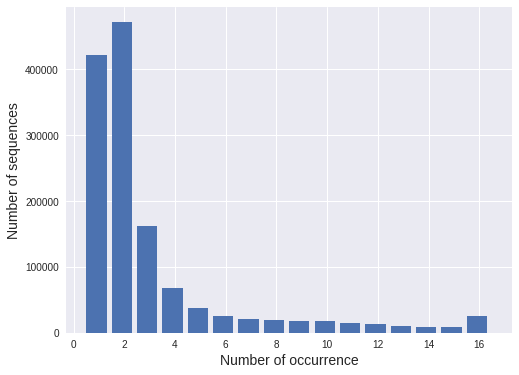

In [52]:
occur = (byo_table.filtered_table > 0).sum(axis=1)
fig, ax = plt.subplots(1, 1, figsize=[8, 6])
bins = np.linspace(0.5, 16.5, 17)
ax.hist(occur, bins=bins, width=0.8)
ax.set_xlabel('Number of occurrence', fontsize=14)
ax.set_ylabel('Number of sequences', fontsize=14)
plt.show()

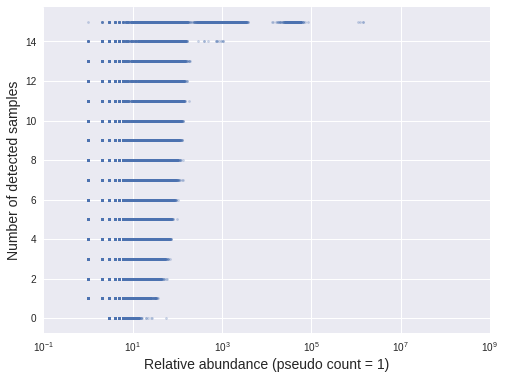

In [61]:
occur = (reacted_pool > 0).sum(axis=1)
rel_abun = (input_pool.R0 + 1)
fig, ax = plt.subplots(1, 1, figsize=[8, 6])
ax.scatter(rel_abun, occur, s=5, alpha=0.3)
ax.set_xlabel('Relative abundance (pseudo count = 1)', fontsize=14)
ax.set_ylabel('Number of detected samples', fontsize=14)
ax.set_xscale('log')
ax.set_xlim([0.1, 1e9])
plt.show()

## Variance of measurements
### Reference free
Don't use spike-in or total DNA amount as absolute amount reference

In [440]:
byo_doped_table.seq_list = list(byo_doped_table.table.index[not_spike_in_filer & length_filter & non_singleton_filter])

## Replicate variance analysis
convert to pkg code for this
  - use grouper and target_table

In [8]:
from k_seq.data.seq_table import Grouper

grouper_info = {
    'input': ['R0'],
    'reacted': {'group': ['A1', 'A2', 'A3', 'B1', 'B2'], 'axis':1},
    'byo': {
        '1250': ['A1', 'A2', 'A3'],
        '250': ['B1', 'B2', 'B3']
    }
}

grouper = Grouper(groupers=grouper_info, target=byo_doped_table.table)

ImportError: cannot import name 'Grouper' from 'k_seq.data.seq_table' (/home/yuning/research/k-seq/src/pkg/k_seq/data/seq_table.py)

In [10]:
byo_table.grouper

In [447]:
byo_doped_table.table

,A1,A2,A3,B1,B2,B3,C1,C2,C3,D1,D2,D3,E1,E2,E3,R0
AAAAAACTGGTAATCGTGCGA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
AAAAAATTAAATAAATCGTTC,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0
AAAAAATTCAAGCAATCGGTC,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
AAAAACAAAAACAAATAGCTC,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0
AAAAACAAAAACAAATAGCTT,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTTTTGCTACTAGTCGCAAG,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
TTTTTTGCTAGTAGTCGCAAG,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
TTTTTTGCTCATAGTCGCAAG,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
TTTTTTGCTGATAGTCGCAAG,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5


In [11]:
from k_seq.data.grouper import Grouper

byo_table.grouper = Grouper(groupers={'input': ['R0']}, target=byo_table.filtered_table)

byo_table.grouper.add({
    'byo':{1250:['A1', 'A2', 'A3'],
           250: ['B1', 'B2', 'B3'],
           50: ['C1', 'C2', 'C3'],
           10: ['D1', 'D2', 'D3'],
           2: ['E1', 'E2', 'E3']}}, target=byo_table.filtered_table
)

In [15]:
byo_table.grouper.byo.target

,A1,A2,A3,B1,B2,B3,C1,C2,C3,D1,D2,D3,E1,E2,E3,R0
CTACTTCAAACAATCGGTCTG,2073359,2223890,4673972,2375053,2925890,2602711,1509853,2060371,2188132,1894508,2005826,1712433,768138,1903080,1535263,1452168
CCACACTTCAAGCAATCGGTC,1918612,2063146,4473364,2005514,2398999,2190556,1125797,1509769,1555068,1362890,1470216,1155490,529124,1337152,1026848,1246770
ATTACCCTGGTCATCGAGTGA,1231995,1116392,2439960,1476384,1534694,1481682,2217682,1945364,2359447,3419619,3071206,3270499,1822663,4514332,4338722,1114058
AAGTTTGCTAATAGTCGCAAG,989320,852125,1917147,1065499,976044,901923,626570,582849,718972,746781,554123,516678,311240,420069,430141,1421715
GTACTTCAAACAATCGGTCTG,98231,93653,199970,99669,114584,100818,58189,75606,77390,71419,70333,55207,27347,59957,47546,85808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACACGCCACACGCAATCGGTC,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
AACTCTGCGAATAATCGCAAG,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
ATTACTATGGTCGTCGAGTGC,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
ATTGCCTTGGTCATCGACAGA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2


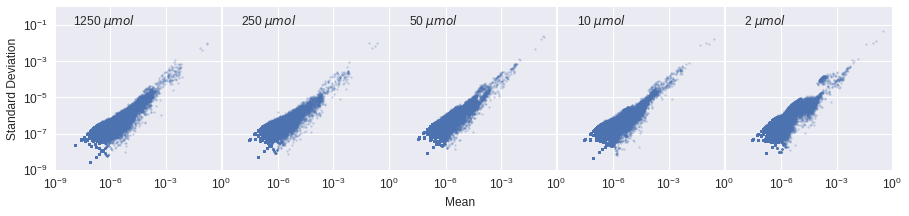

In [17]:
table_gen = byo_table.grouper.byo.get_table(remove_zero=True)

fig, axes = plt.subplots(1, 5, figsize=[15, 3], sharey=True)
fig.subplots_adjust(hspace=0, wspace=0.01)

for ix, ((key, table), ax) in enumerate(zip(table_gen, axes)):
    rel_abun = table / table.sum(axis=0)
    ax.scatter(rel_abun.mean(axis=1), rel_abun.std(axis=1), s=3, alpha=0.3)
    ax.text(s=f'{key:d} $\mu mol$', x=1e-8, y=1e-1, fontsize=12)
    ax.set_xscale('log')
    ax.set_xlim([1e-9, 1])
    ax.set_yscale('log')
    ax.set_ylim([1e-9, 1])
    ax.tick_params(axis='both', labelsize=12)
    if ix > 0:
        xticks = [tick for tick in ax.get_xticks()][2:-1]
        ax.set_xticks(xticks)
    else:
        ax.set_ylabel('Standard Deviation', fontsize=12)
    
fig.text(s='Mean', x=0.5, y=0, ha='center', va='top', fontsize=12)
plt.show()

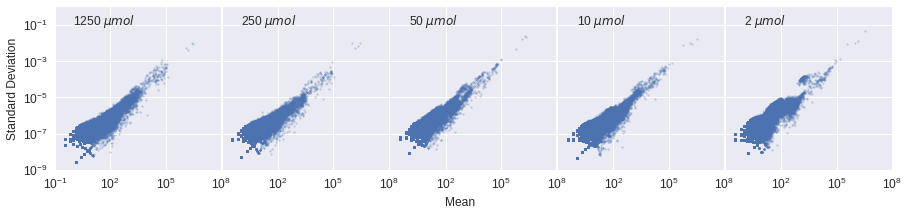

In [32]:
table_gen = byo.grouper.byo.get_table(remove_zero=True)

fig, axes = plt.subplots(1, 5, figsize=[15, 3], sharey=True)
fig.subplots_adjust(hspace=0, wspace=0.01)

for ix, ((key, table), ax) in enumerate(zip(table_gen, axes)):
    rel_abun = table / table.sum(axis=0)
    ax.scatter(table.mean(axis=1), rel_abun.std(axis=1), s=3, alpha=0.3)
    ax.text(s=f'{key:d} $\mu mol$', x=1, y=1e-1, fontsize=12)
    ax.set_xscale('log')
    ax.set_xlim([0.1, 1e8])
    ax.set_yscale('log')
    ax.set_ylim([1e-9, 1])
    ax.tick_params(axis='both', labelsize=12)
    if ix > 0:
        xticks = [tick for tick in ax.get_xticks()][2:-1]
        ax.set_xticks(xticks)
    else:
        ax.set_ylabel('Standard Deviation', fontsize=12)
    
fig.text(s='Mean', x=0.5, y=0, ha='center', va='top', fontsize=12)
plt.show()

In [18]:
from k_seq.data import transform
reload(transform)

spike_in_norm = transform.SpikeInNormalizer(target=byo_doped_table)

A1     120.953173
A2     151.580433
A3     248.651077
B1     138.021484
B2     133.961512
B3     128.976326
C1      70.436195
C2      46.606878
C3      58.256222
D1      15.604318
D2      13.826527
D3      14.989938
E1       4.084483
E2       3.344652
E3       3.170765
R0    1768.776553
dtype: float64

In [21]:
byo_table.spike_in.apply(target=byo_table.filtered_table)

,A1,A2,A3,B1,B2,B3,C1,C2,C3,D1,D2,D3,E1,E2,E3,R0
CTACTTCAAACAATCGGTCTG,20.602660,28.161379,45.606846,28.811920,30.526673,28.873455,11.658106,9.856254,11.781506,2.321473,2.282200,2.253854,0.491679,0.489123,0.413661,25.395233
CCACACTTCAAGCAATCGGTC,19.064962,26.125859,43.649389,24.329019,25.029464,24.301169,8.692675,7.222324,8.372915,1.670045,1.672791,1.520822,0.338688,0.343670,0.276674,21.803273
ATTACCCTGGTCATCGAGTGA,12.242151,14.137002,23.808204,17.910109,16.011915,16.437199,17.123503,9.306092,12.703913,4.190299,3.494375,4.304534,1.166672,1.160258,1.169026,19.482431
AAGTTTGCTAATAGTCGCAAG,9.830726,10.790558,18.706793,12.925637,10.183355,10.005580,4.837967,2.788191,3.871144,0.915083,0.630473,0.680036,0.199222,0.107965,0.115897,24.862677
GTACTTCAAACAATCGGTCTG,0.976107,1.185939,1.951231,1.209091,1.195489,1.118435,0.449298,0.361679,0.416689,0.087515,0.080024,0.072662,0.017505,0.015410,0.012811,1.500594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACACGCCACACGCAATCGGTC,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000035
AACTCTGCGAATAATCGCAAG,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000035
ATTACTATGGTCGTCGAGTGC,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000035
ATTGCCTTGGTCATCGACAGA,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000035


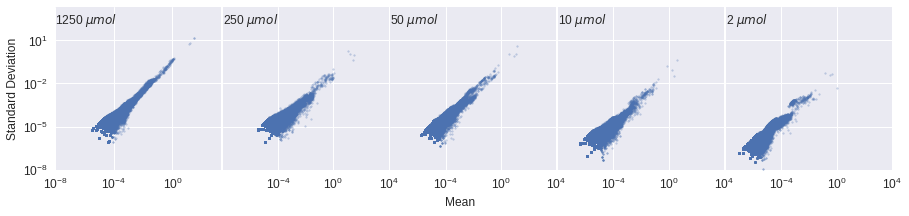

In [22]:
table_gen = byo_table.grouper.byo.get_table(target=byo_table.spike_in.apply(target=byo_table.filtered_table), remove_zero=True)

fig, axes = plt.subplots(1, 5, figsize=[15, 3], sharey=True)
fig.subplots_adjust(hspace=0, wspace=0.01)

for ix, ((key, table), ax) in enumerate(zip(table_gen, axes)):
    ax.scatter(table.mean(axis=1), table.std(axis=1), s=3, alpha=0.3)
    ax.text(s=f'{key:d} $\mu mol$', x=1e-8, y=1000, va='top', fontsize=12)
    ax.set_xscale('log')
    ax.set_xlim([1e-8, 2000])
    ax.set_yscale('log')
    ax.set_ylim([1e-8, 2000])
    ax.tick_params(axis='both', labelsize=12)
    if ix > 0:
        xticks = [tick for tick in ax.get_xticks()][2:-1]
        ax.set_xticks(xticks)
    else:
        ax.set_ylabel('Standard Deviation', fontsize=12)
    
fig.text(s='Mean', x=0.5, y=0, ha='center', va='top', fontsize=12)
plt.show()

In [560]:
byo_doped_table.table

,A1,A2,A3,B1,B2,B3,C1,C2,C3,D1,D2,D3,E1,E2,E3,R0
AAAAAACTGGTAATCGTGCGA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
AAAAAATTAAATAAATCGTTC,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0
AAAAAATTCAAGCAATCGGTC,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
AAAAACAAAAACAAATAGCTC,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0
AAAAACAAAAACAAATAGCTT,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTTTTGCTACTAGTCGCAAG,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
TTTTTTGCTAGTAGTCGCAAG,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
TTTTTTGCTCATAGTCGCAAG,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
TTTTTTGCTGATAGTCGCAAG,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5


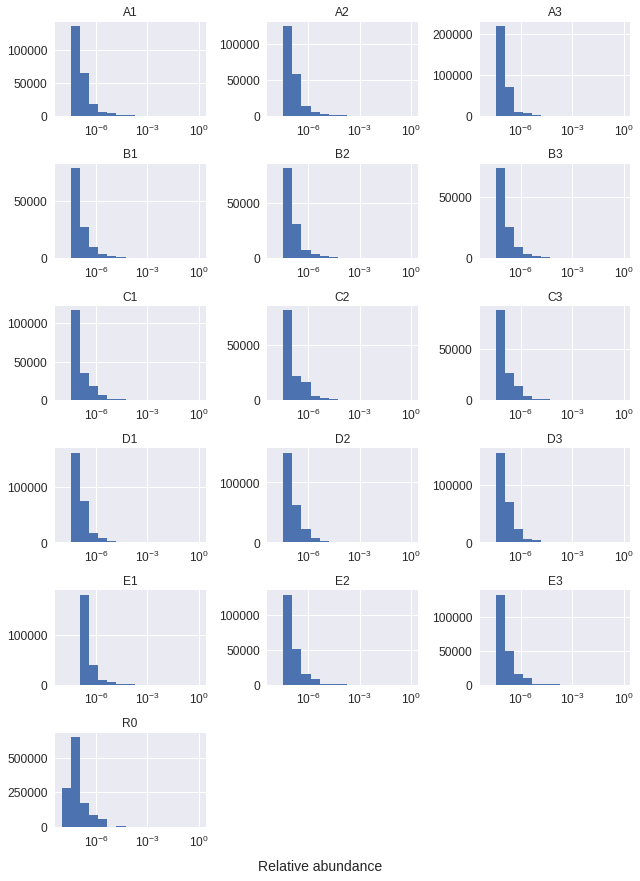

In [569]:
seq_table_vis.sample_rel_abun_hist(seq_table=byo_doped_table)

/home/yuning/.pyenv/versions/k-seq/lib/python3.7/site-packages/pandas/core/indexing.py:2418: FutureWarning: DataFrame/Series.to_dense is deprecated and will be removed in a future version
  result = result.to_dense()


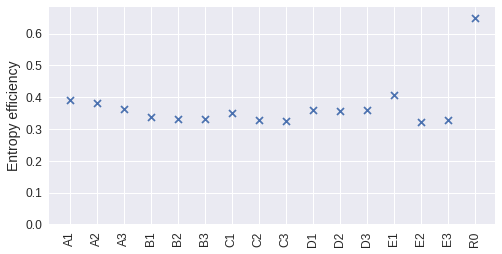

In [605]:
seq_table_vis.sample_entropy_scatterplot(byo_doped_table, normalize=True)

In [111]:
from k_seq.data import filters
reload(filters)

<module 'k_seq.data.filters' from '/home/yuning/research/k-seq/src/pkg/k_seq/data/filters.py'>

In [93]:
spike_in_filter = filters.SpikeInFilter(target=byo_doped_table)
spike_in_filter.summary()

,unique,unique_passed,total,total_passed
A1,366471,366471,12808719,12808719
A2,324369,324369,12528391,12528391
A3,514251,514251,26534366,26534366
B1,180803,180803,11820568,11820568
B2,188013,188013,13334445,13334445
B3,168492,168492,12090627,12090627
C1,276163,276163,9516938,9516938
C2,185372,185372,10178038,10178038
C3,200071,200071,11247585,11247585
D1,435084,435084,13318223,13318223


In [105]:
seq_length_filter = filters.SeqLengthFilter(target=byo_doped_table, min_len=21, max_len=21)

In [106]:
seq_length_filter.summary()

,unique,unique_passed,total,total_passed
A1,366471,290866,12808719,12424891
A2,324369,258704,12528391,12172314
A3,514251,403588,26534366,25775801
B1,180803,144242,11820568,11557233
B2,188013,149987,13334445,13046006
B3,168492,134263,12090627,11818575
C1,276163,219466,9516938,9285494
C2,185372,147609,10178038,9965328
C3,200071,159508,11247585,11022884
D1,435084,342290,13318223,12964895


In [70]:
from k_seq.data import transform
reload(transform)

byo_doped_table.metadata.spike_in = transform.SpikeInNormalizer(
    spike_in_seq='AAAAACAAAAACAAAAACAAA',
    spike_in_amount=np.concatenate((
                    np.repeat([2, 2, 1, 0.2, .04], repeats=3),
                    np.array([10/3])), axis=0
                ),
    radius=4,
    target=byo_doped_table
)

In [113]:
sing_filter = filters.SingletonFilter(target=byo_doped_table)

In [114]:
sing_filter.summary()

,unique,unique_passed,total,total_passed
A1,366471,280716,12808719,12722964
A2,324369,251837,12528391,12455859
A3,514251,376303,26534366,26396418
B1,180803,149694,11820568,11789459
B2,188013,155533,13334445,13301965
B3,168492,140257,12090627,12062392
C1,276163,218899,9516938,9459674
C2,185372,153070,10178038,10145736
C3,200071,163767,11247585,11211281
D1,435084,326904,13318223,13210043


## Compare to pool design

Convert to a doped_pool.py

In [139]:
from k_seq.data import landscape
reload(landscape)

pool_peaks = {
    'pk2': 'ATTACCCTGGTCATCGAGTGA',
    'pk1A': 'CTACTTCAAACAATCGGTCTG',
    'pk1B': 'CCACACTTCAAGCAATCGGTC',
    'pk3': 'AAGTTTGCTAATAGTCGCAAG'
}

pool_peaks = [landscape.Peaks(target=byo_table, center_seq=seq, name=name, radius=5)
              for name, seq in pool_peaks.items()]

In [141]:
mega_peak = landscape.Peaks.from_peak_list(pool_peaks)

In [155]:
pool_peaks[0].peak_abun(max_radius=5)[['A1', 'A2', 'A3']]

,A1,A2,A3
0,0.096184,0.089109,0.091955
1,0.171135,0.154632,0.157799
2,0.199262,0.179027,0.181491
3,0.209968,0.188294,0.190260
4,0.213991,0.191814,0.193514
5,0.215317,0.192954,0.194560


In [188]:
def peak_abun_plot(peak, max_radius, rel_abun_table=None, sample_grouper=None, sample_plot_kwargs=None, ax=None, save_fig_to=None):
    peak_abun_info = peak.peak_abun(max_radius=max_radius,
                                        rel_abun_table=rel_abun_table)
    
    if sample_grouper is not None:
        peak_abun_info = pd.DataFrame.from_dict(
            {x_val: peak_abun_info[group].mean(axis=1)
             for x_val, group in sample_grouper.items()},
            orient='columns'
        )
        
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=[8, 6])
    if sample_plot_kwargs is None:
        from k_seq.utility.plot_tools import PlotPreset
        colors = PlotPreset.colors(num=len(peak_abun_info.columns))
        markers = PlotPreset.markers(num=len(peak_abun_info.columns), with_line=False)
        sample_plot_kwargs = {
            sample: {'color': color,
                     'marker': marker}
            for sample, color, marker in zip(peak_abun_info.columns, colors, markers)
        }
    loc = np.arange(0, max_radius + 1)
    for sample in peak_abun_info.columns:
        ax.plot(loc, peak_abun_info[sample], ls='-', markeredgewidth=2, **sample_plot_kwargs[sample], label=sample)
        
    ax.set_ylabel('Relative abundance', fontsize=14)
    ax.set_xlabel('Peak radius (edit distance)', fontsize=14)
    ax.tick_params(labelsize=12)
    ax.text(s=peak.name, x=0, y=ax.get_ylim()[1] * 0.9, fontsize=18, color='#151515')
    
    if save_fig_to:
        fig.savefig(save_fig_to, bbox_inches='tight', dpi=300)

/home/yuning/research/k-seq/src/pkg/k_seq/data/landscape.py:57: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


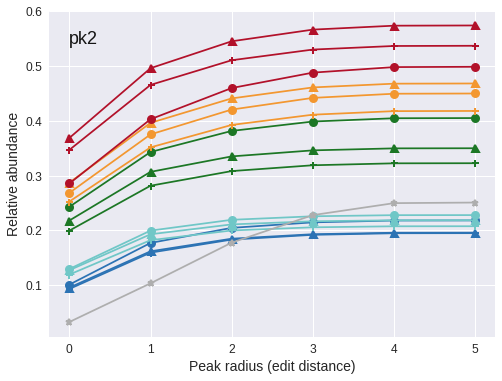

In [189]:
sample_plot_kwargs = {
    'R0': {'color': '#AEAEAE', 'marker': '*'}
}

color_list = ['#2C73B4', '#70C7C7', '#1C7725', '#F39730', '#B2112A']
marker_list = ['o', '+', '^']

for byo, color in zip(['A', 'B', 'C', 'D', 'E'], color_list):
    for rep, marker in zip(['1', '2', '3'], marker_list):
        sample_plot_kwargs[byo + rep] = {'color': color, 'marker': marker}
        
peak_abun_plot(peak=pool_peaks[0], max_radius=5, sample_plot_kwargs=sample_plot_kwargs, rel_abun_table=byo_table.filtered_rel_abun)

/home/yuning/research/k-seq/src/pkg/k_seq/data/landscape.py:57: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


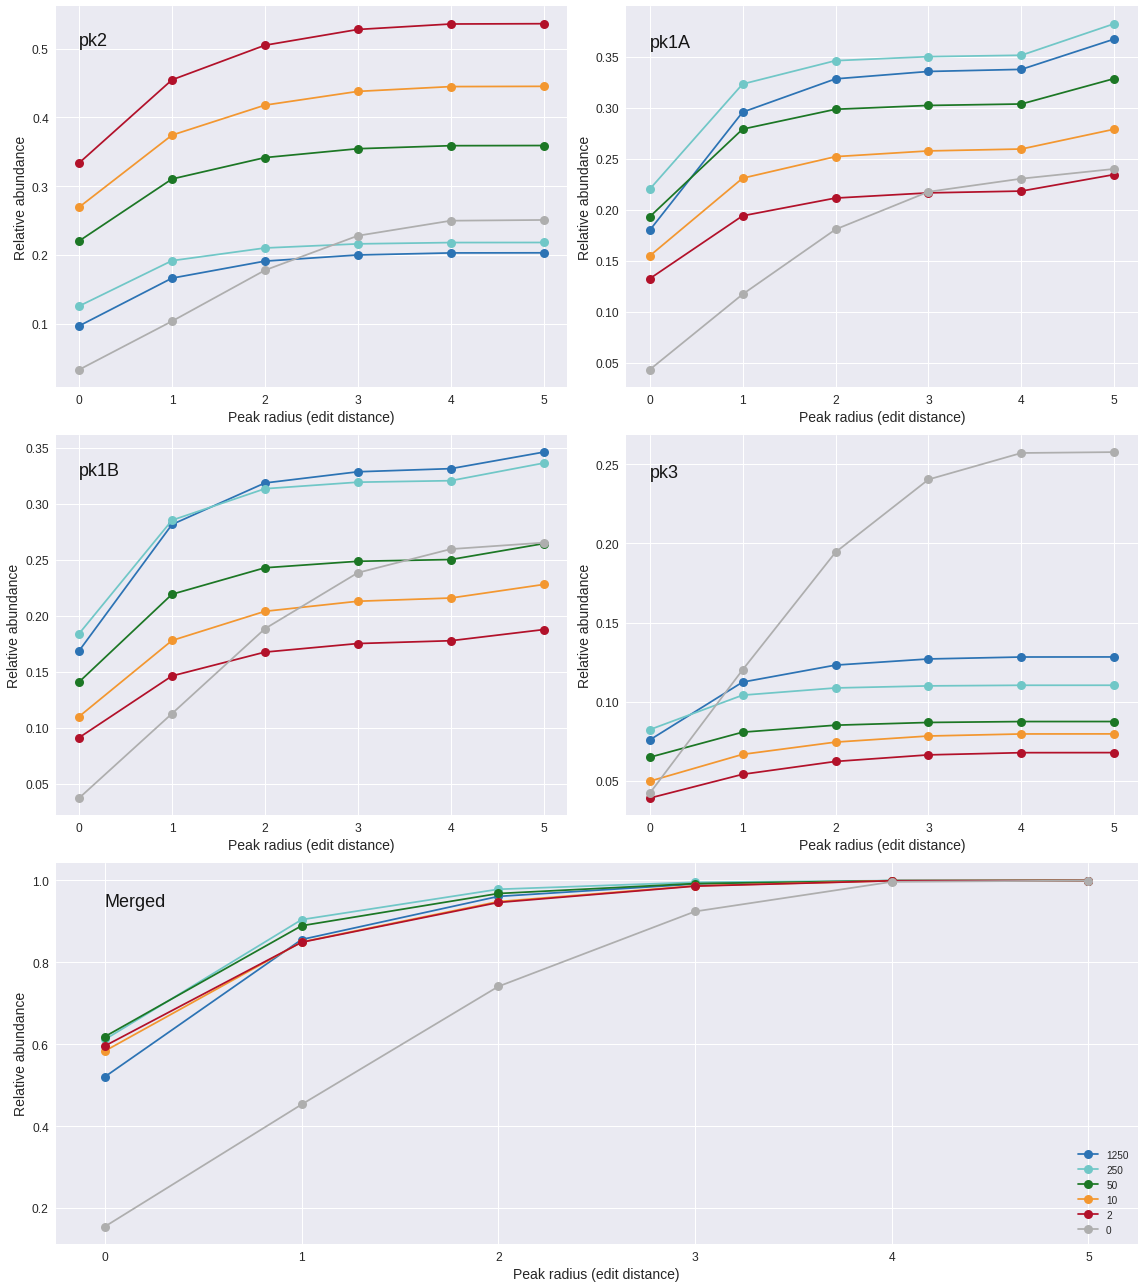

In [192]:
fig = plt.figure(figsize=[16, 18], constrained_layout=False)
gs = fig.add_gridspec(3, 2)

sample_grouper = {
    1250: ['A1', 'A2', 'A3'],
    250: ['B1', 'B2', 'B3'],
    50: ['C1', 'C2', 'C3'],
    10: ['D1', 'D2', 'D3'],
    2: ['E1', 'E2', 'E3'],
    0: ['R0']
}

axes = [
    fig.add_subplot(gs[0, 0]),
    fig.add_subplot(gs[0, 1]),
    fig.add_subplot(gs[1, 0]),
    fig.add_subplot(gs[1, 1]),
    fig.add_subplot(gs[2, :])
]


sample_plot_kwargs = {
    1250: {'color': '#2C73B4', 'marker': 'o', 'alpha': 1},
    250: {'color': '#70C7C7', 'marker': 'o', 'alpha': 1},
    50: {'color': '#1C7725', 'marker': 'o', 'alpha': 1},
    10: {'color': '#F39730', 'marker': 'o', 'alpha': 1},
    2: {'color': '#B2112A', 'marker': 'o', 'alpha': 1},
    0: {'color': '#AEAEAE', 'marker': 'o', 'alpha': 1},
}
        
peak_list = pool_peaks + [landscape.Peaks.from_peak_list(pool_peaks)]
peak_list[-1].name = 'Merged'

for peak, ax in zip(peak_list, axes):
    peak_abun_plot(peak=peak, max_radius=5, sample_grouper=sample_grouper,
                   sample_plot_kwargs=sample_plot_kwargs,
                   rel_abun_table=byo_table.filtered_rel_abun, ax=ax)
axes[-1].legend(loc='lower right')
plt.tight_layout()
plt.show()

In [178]:
def peak_abun_kin_plot(peak, max_radius, sample_grouper, rel_abun_table=None, sample_plot_kwargs=None, ax=None, save_fig_to=None):
    peak_abun_info = peak.peak_abun(max_radius=max_radius,
                                    rel_abun_table=rel_abun_table)
    
    peak_abun_kin_info = pd.DataFrame.from_dict(
        {x_val: peak_abun_info[group].mean(axis=1)
         for x_val, group in sample_grouper.items()},
        orient='index'
    )
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=[8, 6])
        
    if sample_plot_kwargs is None:
        from k_seq.utility.plot_tools import PlotPreset
        colors = PlotPreset.colors(num=len(peak_abun_kin_info.columns))
        markers = PlotPreset.markers(num=len(peak_abun_kin_info.columns), with_line=False)
        sample_plot_kwargs = {
            sample: {'color': color,
                     'marker': marker}
            for sample, color, marker in zip(peak_abun_kin_info.columns, colors, markers)
        }
        
    loc = peak_abun_kin_info.index
    
    for dist in peak_abun_kin_info.columns:
        ax.plot(loc, peak_abun_kin_info[dist], ls='-', markeredgewidth=2, **sample_plot_kwargs[dist], label=f'dist = {dist}')
        
    ax.set_ylabel('Relative abundance', fontsize=14)
    ax.set_xlabel('BYO concentration', fontsize=14)
    ax.tick_params(labelsize=12)
    ylims = ax.get_ylim()
    ax.set_ylim([ylims[0], ylims[1] * 1.2])
    ax.text(s=peak.name, x=0, y=ylims[1] * 1.1, fontsize=18, color='#151515')
    
    if save_fig_to:
        fig.savefig(save_fig_to, bbox_inches='tight', dpi=300)

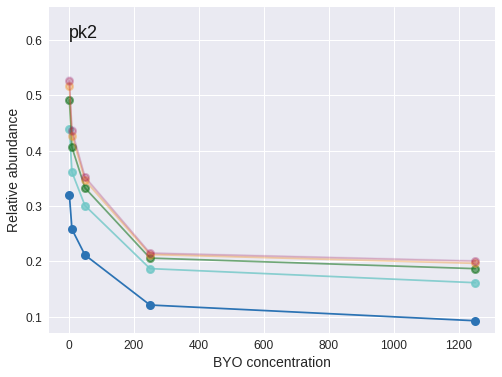

In [179]:
peak_abun_kin_plot(peak_list[0], max_radius=5, sample_grouper=sample_grouper, sample_plot_kwargs=sample_plot_kwargs)

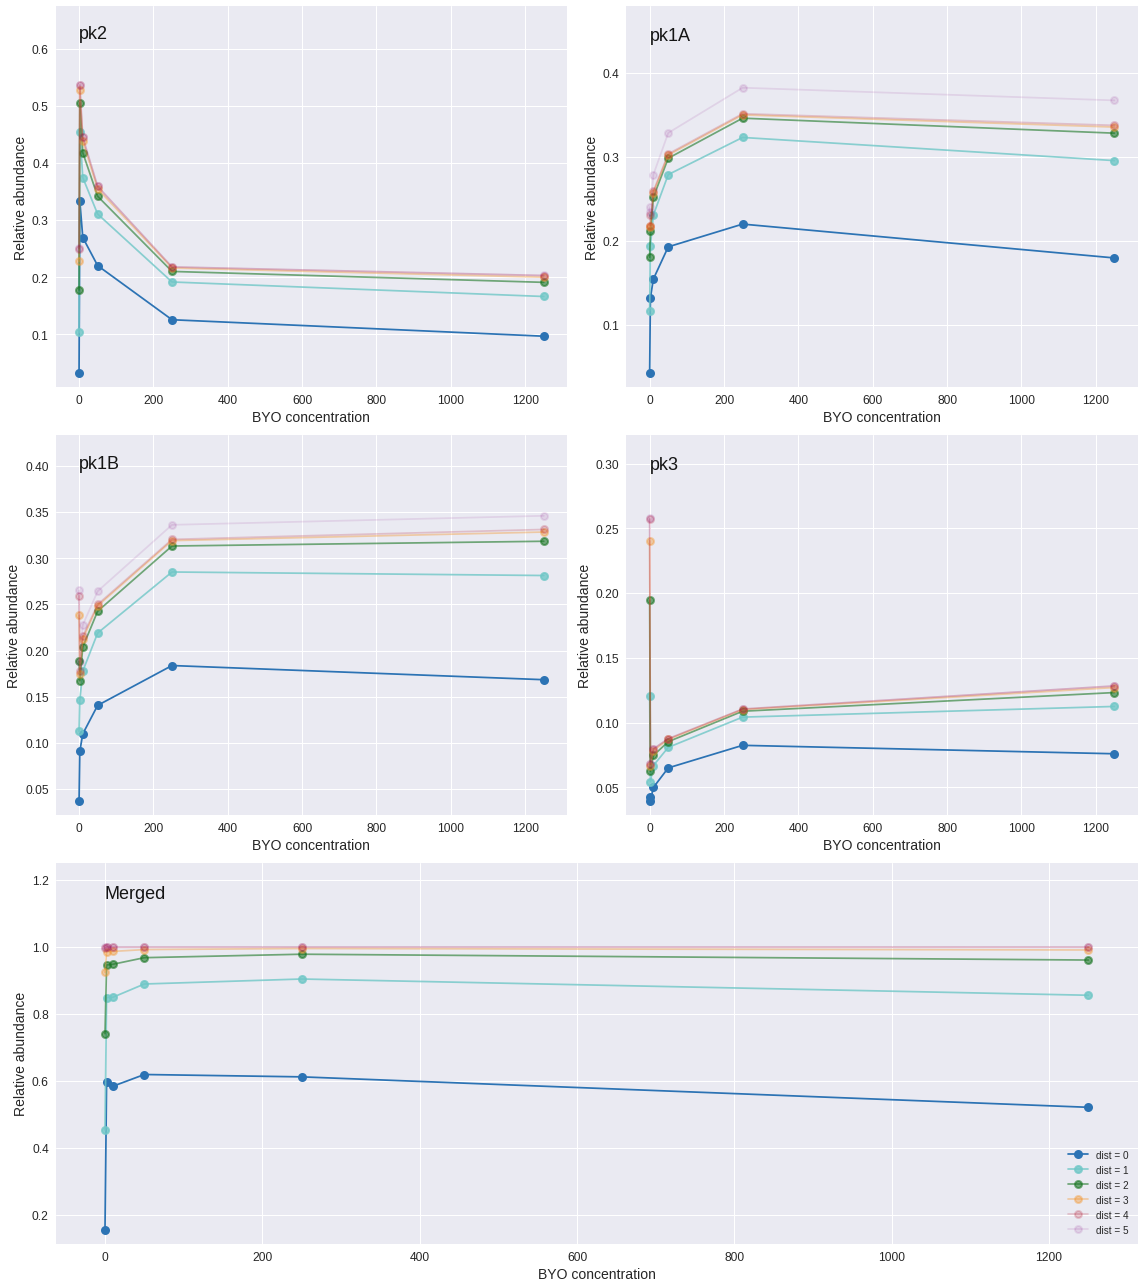

In [185]:
sample_grouper = {
    1250: ['A1', 'A2', 'A3'],
    250: ['B1', 'B2', 'B3'],
    50: ['C1', 'C2', 'C3'],
    10: ['D1', 'D2', 'D3'],
    2: ['E1', 'E2', 'E3'],
    0: ['R0']
}

sample_plot_kwargs = {
    0: {'color': '#2C73B4', 'marker': 'o', 'alpha': 1},
    1: {'color': '#70C7C7', 'marker': 'o', 'alpha': 0.8},
    2: {'color': '#1C7725', 'marker': 'o', 'alpha': 0.6},
    3: {'color': '#F39730', 'marker': 'o', 'alpha': 0.4},
    4: {'color': '#B2112A', 'marker': 'o', 'alpha': 0.2},
    5: {'color': '#810080', 'marker': 'o', 'alpha': 0.1},
}

fig = plt.figure(figsize=[16, 18], constrained_layout=False)
gs = fig.add_gridspec(3, 2)
axes = [
    fig.add_subplot(gs[0, 0]),
    fig.add_subplot(gs[0, 1]),
    fig.add_subplot(gs[1, 0]),
    fig.add_subplot(gs[1, 1]),
    fig.add_subplot(gs[2, :])
]
        
peak_list = pool_peaks + [landscape.Peaks.from_peak_list(pool_peaks)]
peak_list[-1].name = 'Merged'

for peak, ax in zip(peak_list, axes):
    peak_abun_kin_plot(peak=peak, max_radius=5,
                       sample_grouper=sample_grouper,
                       sample_plot_kwargs=sample_plot_kwargs,
                       rel_abun_table=byo_table.filtered_rel_abun, ax=ax)
axes[-1].legend()
plt.tight_layout()
plt.show()

In [343]:
func_tools.dict_flatten(pd.DataFrame(data=[[0, 1], [3, 1]], index=['ix1', 'ix2'], columns=['col1', 'col2']).to_dict())

{'col1_ix1': 0, 'col1_ix2': 3, 'col2_ix1': 1, 'col2_ix2': 1}

In [308]:
test_series = pd.Series(data=[0, 1, 2, 3, 4], index=[0, 1, 2, 3, 4])

In [347]:
np.full(fill_value=np.nan, shape=(2))

array([nan, nan])

# Parameter estimation
## Classic fitting using spike-in to normalized and fit into kinetic modelindividually

In [178]:
seq_test = byo_doped.reacted_frac_filtered.index.values[-1000:-1]
print(seq_test)

['CCTCACTTCAATCAATCCGTG' 'AATACCCTGGTCTTGGAGCGA' 'AGGTTTTCTAATACTCGCATG'
 'CCACACTTAAAGCACTTCGTC' 'TCACTCCAAAGAATCGGTCTG' 'ATTATTCTTGTAATCGGGTGA'
 'CCAAACTACGAGCAATCGTTC' 'ATTGCCCTAGTCACCGAGTGG' 'AAGTTTGCCTAGAGTCGCTAG'
 'CGACTTCAAACAATCGGCAAG' 'AAGTTTTCTACTATTCGCACG' 'AAGCATGGTAATAGACGCAAG'
 'AAGCTTAGTAATAGTGGCAAG' 'ATTACCCCCGTTATCGAGTGC' 'ATTTCTCTTGTAATCAAGTGA'
 'ACTACCACGGGCATCGAGTGA' 'CCACGCTTGAATTAATCGGTC' 'ATAACCCTGGCCATGGTGTGA'
 'AAGTGTGCTGATAGACGCAAT' 'CTACTTCCAACAACAGGTCAG' 'ATTTGCCTGGTTATCTAGTGG'
 'AAGTTTGTCAATAGTGGCATG' 'ATTAGCACGGTCATCGGGTGA' 'TCTCAGGTCTAGCAATCGGTC'
 'CTACTTCGAACAGTCGATCTC' 'ATTACCTTGGTTTTGGAGTGA' 'ATAACACTGCTCATCAAGTGA'
 'CTAGACTTCAAGCAGGCGGTC' 'AAAGCCCTGGTCATTGAGTGA' 'GTAATTCAAACACTCGGTGTG'
 'ATTACCCTTGTTATAGACTGA' 'ACGCTTGCTATGAGTCGCATG' 'CCTCACATGAAGCATTCGGTC'
 'CCAGACTTCACAGAATCGGTC' 'CTACTTCAATCACTCGGGGTG' 'CTACGCTTCAAGAAATCAGTC'
 'CCAGACTTCAGGCAACCGGTA' 'CCACACTCCAAGTAATGGGAC' 'AGTACCCTGGTCTGCGAGTTA'
 'CGAATTCCAACAACCGGTCTG' 'AAGCTTGCAAATAATGGCAAG' 'A

limit_output extension: Maximum message size of 10000 exceeded with 24310 characters

In [89]:
from k_seq.estimator import least_square
from k_seq.model import kinetic
reload(kinetic)
reload(least_square)
reload(func_tools)

single_fitter = least_square.SingleFitter.from_table(
    table=byo_doped.reacted_frac_filtered,
    seq=seq_test[0],
    model=kinetic.BYOModel.func_react_frac_no_slope,
    x_data=byo_doped.x_values,
    bootstrap_num=100,
    bs_method='stratified',
    metrics={'kA':lambda params: params[0] * params[1]},
    grouper=byo_doped.grouper.byo.group
)

In [43]:
%timeit single_fitter.fit()

36.4 ms ± 1.83 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [47]:
%timeit single_fitter.fit()

483 ms ± 9.82 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [49]:
%timeit single_fitter.fit()

4.01 s ± 52.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [90]:
single_fitter.fit()

In [40]:
40.3 * byo_doped.reacted_frac_filtered.shape[0] / 3600 / 24 / 40

10.90587265625

In [91]:
single_fitter.results.to_series()

k           209.580016
A             0.419281
kA           87.872850
k_mean      209.476407
k_std        59.199596
k_2.5%      101.997716
k_50%       209.939408
k_97.5%     308.472979
A_mean        0.430003
A_std         0.067893
A_2.5%        0.327113
A_50%         0.419257
A_97.5%       0.597296
kA_mean      86.200868
kA_std       12.454793
kA_2.5%      60.871445
kA_50%       87.914071
kA_97.5%    105.208670
Name: CTACTTCAAACAATCGGTCTG, dtype: float64

In [71]:
single_fitter.results.to_series()

k           209.581331
A             0.419280
kA           87.873309
k_mean      211.563051
k_std        49.485723
k_2.5%      108.653713
k_50%       214.546126
k_97.5%     299.581954
A_mean        0.387102
A_std         0.039399
A_2.5%        0.340258
A_50%         0.376575
A_97.5%       0.481871
kA_mean      80.461452
kA_std       14.906638
kA_2.5%      53.136396
kA_50%       80.863022
kA_97.5%    108.478630
Name: CTACTTCAAACAATCGGTCTG, dtype: float64

In [193]:
reload(least_square)
batch_fitter = least_square.BatchFitter(table=byo_doped.reacted_frac_filtered, x_values=byo_doped.x_values, model=kinetic.BYOModel.func_react_frac_no_slope, seq_to_fit=seq_test, bootstrap_num=0)

In [194]:
batch_fitter.fit(deduplicate=True, parallel_cores=10)

Shrink rows in table by removing duplicates: 999 -->8
Recovering original table...


In [195]:
batch_fitter.summary(save_to='some.csv')

byo-doped-pool.ipynb  individual_fitting.ipynb	      test.pkl
data_property.ipynb   model_test.ipynb
evan_bfo.ipynb	      seq_err_correction_dada2.ipynb


In [168]:
(3 * 60 + 17) * 20 / 60

65.66666666666667

In [22]:
byo_doped.table.loc[['TAACGTTTCAAGCAATCGGTC', 'CCTGCCTTCAACCAATCGGTC', 'ATAATTCATTCAATCGTTCTT']]

,A1,A2,A3,B1,B2,B3,C1,C2,C3,D1,D2,D3,E1,E2,E3,R0
TAACGTTTCAAGCAATCGGTC,6,3,4,1,2,0,1,2,0,2,2,1,0,0,0,0
CCTGCCTTCAACCAATCGGTC,6,1,3,2,4,2,2,2,1,3,4,0,0,1,3,0
ATAATTCATTCAATCGTTCTT,7,1,3,3,2,1,1,1,1,1,0,0,0,3,2,0


In [52]:
byo_doped.filtered_table

,A1,A2,A3,B1,B2,B3,C1,C2,C3,D1,D2,D3,E1,E2,E3,R0
seq,,,,,,,,,,,,,,,,
CTACTTCAAACAATCGGTCTG,2073359,2223890,4673972,2375053,2925890,2602711,1509853,2060371,2188132,1894508,2005826,1712433,768138,1903080,1535263,1452168
CCACACTTCAAGCAATCGGTC,1918612,2063146,4473364,2005514,2398999,2190556,1125797,1509769,1555068,1362890,1470216,1155490,529124,1337152,1026848,1246770
ATTACCCTGGTCATCGAGTGA,1231995,1116392,2439960,1476384,1534694,1481682,2217682,1945364,2359447,3419619,3071206,3270499,1822663,4514332,4338722,1114058
AAGTTTGCTAATAGTCGCAAG,989320,852125,1917147,1065499,976044,901923,626570,582849,718972,746781,554123,516678,311240,420069,430141,1421715
GTACTTCAAACAATCGGTCTG,98231,93653,199970,99669,114584,100818,58189,75606,77390,71419,70333,55207,27347,59957,47546,85808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACACGCCACACGCAATCGGTC,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
AACTCTGCGAATAATCGCAAG,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
ATTACTATGGTCGTCGAGTGC,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2


In [49]:
X = pd.DataFrame({'c': byo_doped.x_values, 'n':N}).transpose()

In [51]:
X.to_csv('/mnt/storage/projects/k-seq/datasets/count_tests/byo_doped/X.csv')